# Geolocalization of DAS channels using GPS-tracked vehicle
@Author: Ettore Biondi - ebiondi@caltech.edu

This notebook shows how the latitude and longitude positions of a vehicle can be used to geolocate the channels of a distributed acoustic sensing (DAS) system that employs an onshore dark fiber.

In [54]:
%matplotlib widget
import sys
sys.path.insert(0,"../Python")
import TapTestWdgts
import numpy as np
import pandas as pd
import os
from scipy.interpolate import interp1d
from scipy.signal import hilbert
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
params = {
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 12,
    'font.size': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'text.usetex':False
}
matplotlib.rcParams.update(params)

First, let's download the necessary data to run this tutorial.

In [55]:
# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1H0b03u8oH4kivUJneL4Be4RX4lGEI8Dx' -O ../Dat/Event.npz
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1lq0f5Y1pnufqzloBmXRL0dabNTh6Xdpo' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1lq0f5Y1pnufqzloBmXRL0dabNTh6Xdpo" -O ../Dat/Traffic.npz && rm -rf /tmp/cookies.txt
# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=16DTe1Ovs0bbgUnudrXNoI2ci5Izv3wav' -O ../Dat/FiberShortReg.npz

Let's load a recorded earthquake and use it to identify bad channels and fiber loops (or manhole).

In [56]:
# with np.load("../Dat/Event.npz") as dat:
#     dataEq = dat['data']
#     dt = dat['dt'].item()

Now we can start the interactive plots to easily identify the channels that we want to be removed from the data. The "bad channels" widget can be used to type the channel that are not recording useful seismic signal. The user has to provide a comma-separated list of channel numbers from 0 to the total number of channels (e.g., 0,1,2,3,...). It is also possible to provide an interval of channels by using two indices separated by a column (e.g., 0:3,10:32,...).
For this specific system, the identified bad channels are the following: 
0:9,107:119,203:209,355:362,497:509,561:566,782:792,1010:1017,1212:1229,1259:1264,1496,1497,1631:1637,1698:1716,1938:1951,2148:2153,2443:2453,2540:2550,2692:2704,2892:2903,3065:3077,3174,3214:3221,3253:3259,3393:3401,3602:3616,3840:3849,3929:3943,3973:3983,4164:4179,4398:4413,4617:4635,4853:4862,1611,1613,4987:5000
One can copy this list and paste it in the "bad channels" widget.
The bottom widgets provide control on the visualized data. The interface should be intuitive. If non-valid values are set, an error message should appear below the widgets.

In [57]:
# badCh = TapTestWdgts.badchnnlwdgt(dataEq, dt)
# badCh

Let's now extract a mask to plot the data without the bad channels.

In [58]:
# mask_bad = np.ones(dataEq.shape[0], dtype=bool)
# mask_bad[badCh.bad_channels] = False
# data_good = dataEq[mask_bad]

In [59]:
# # Plotting w/o loops and trace normalization
# data_norm = data_good.copy()
# # Plotting the two systems' data together
# fig, ax = plt.subplots(figsize=(10,6))
# # North system
# min_t = 6.0
# max_t = 17.0
# it_min = int((min_t)/dt+0.5)
# it_max = int((max_t)/dt+0.5)
# std_data = np.std(data_norm[:,it_min:it_max],axis=1)
# data_norm /= np.expand_dims(std_data,axis=1)
# clipVal = np.percentile(np.absolute(data_norm[:,it_min:it_max]), 95)
# ax.imshow(data_norm[:,it_min:it_max].T, 
#            extent=[0, data_norm.shape[0], max_t, min_t],
#            aspect='auto', vmin=-clipVal, vmax=clipVal, cmap=plt.get_cmap('seismic'))
# ax.set_ylabel("Time [s]")
# ax.set_xlabel("Channel number")
# ax.grid()

Now we can use the GPS points of the tracked vehicle used during the tap-test experiment to locate the DAS system channels. We start by loading the necessary data.

In [60]:
with np.load("SISSLE_N_Traffic.npz",allow_pickle=True) as dat:
    dataTap = dat['data']
    dt       = dat['dt'].item()
    import datetime
    ot       = dat['ot'].item() 
    dCh      = dat['dCh'].item()
    gps_lat  = dat['gps_lat']
    gps_lon  = dat['gps_lon']
    gps_time  = dat['gps_time']

In [61]:
# Loading fiber locations at 1 m spacing
with np.load("SISSLE_N_FiberShortReg.npz",allow_pickle=True) as dat:
    fiber_lat = dat['lat']
    fiber_lon = dat['lon']
    fiber_dist = dat['dist']

# Let's map the car locations onto the closest fiber points    
close_ch = TapTestWdgts.find_close_ch(gps_lat,gps_lon,fiber_lat,fiber_lon)
fiber_dist_vehicle = fiber_dist[close_ch]

Now we have all the necessary inputs for proceeding with the geolocalization of the DAS channels of this system. Once the interactive plot is started, the first step is to copy the list of bad channels that we have identified before. Obviously, in this step, additional bad channels can be found and removed if necessary. To correctly calibrate the channel positions, one must uncheck the "Show bad channel" toggle switch.
After this visual check, we need to align the red dashed line with the car-tracked generated signal. To provide an example of this process, change the display options to visualize the data between the channel numbers 500 and 1800 and the first 600 seconds. Now, apply a "Tap-test shift" of -46.4 and turn off and on the "Show tap-test line" switch to see the alignment of a signal with the calibration line. Thus, we can map with confidence that the displayed channels have been excited by the tracked-car movement. Change the min and max "map ch" slidebars to 500 and 1800, and hit map channels. You should be able to see the mapped channels in the top panel of the interactive plot.
We can now proceed to other sections of the cable. 

The second section can be mapped with the following parameters: 
min channel=1800
max channel=2300
min time=500
max time=910
min map ch=500
max map ch=910

The small gap between the two section can be easily filled by a linear interpolation, which is done in the cells below. One could use u-turns to identify the tracked car, but when mapping one should visualize only a single direction curve (i.e., towards or away from the interrogator unit) before hitting the map channel button.

For the purpose of this tutorial, only the first 25 km of the fiber geometry are provided. Thus, one can only map approximately the first 2500 DAS channels.

The variable **filename** below should be populated by the user in that previous box, or else the next box will throw an error. Finally, if bad channels have been identified, remember to uncheck the **Show bad channels** box before mapping any channel.

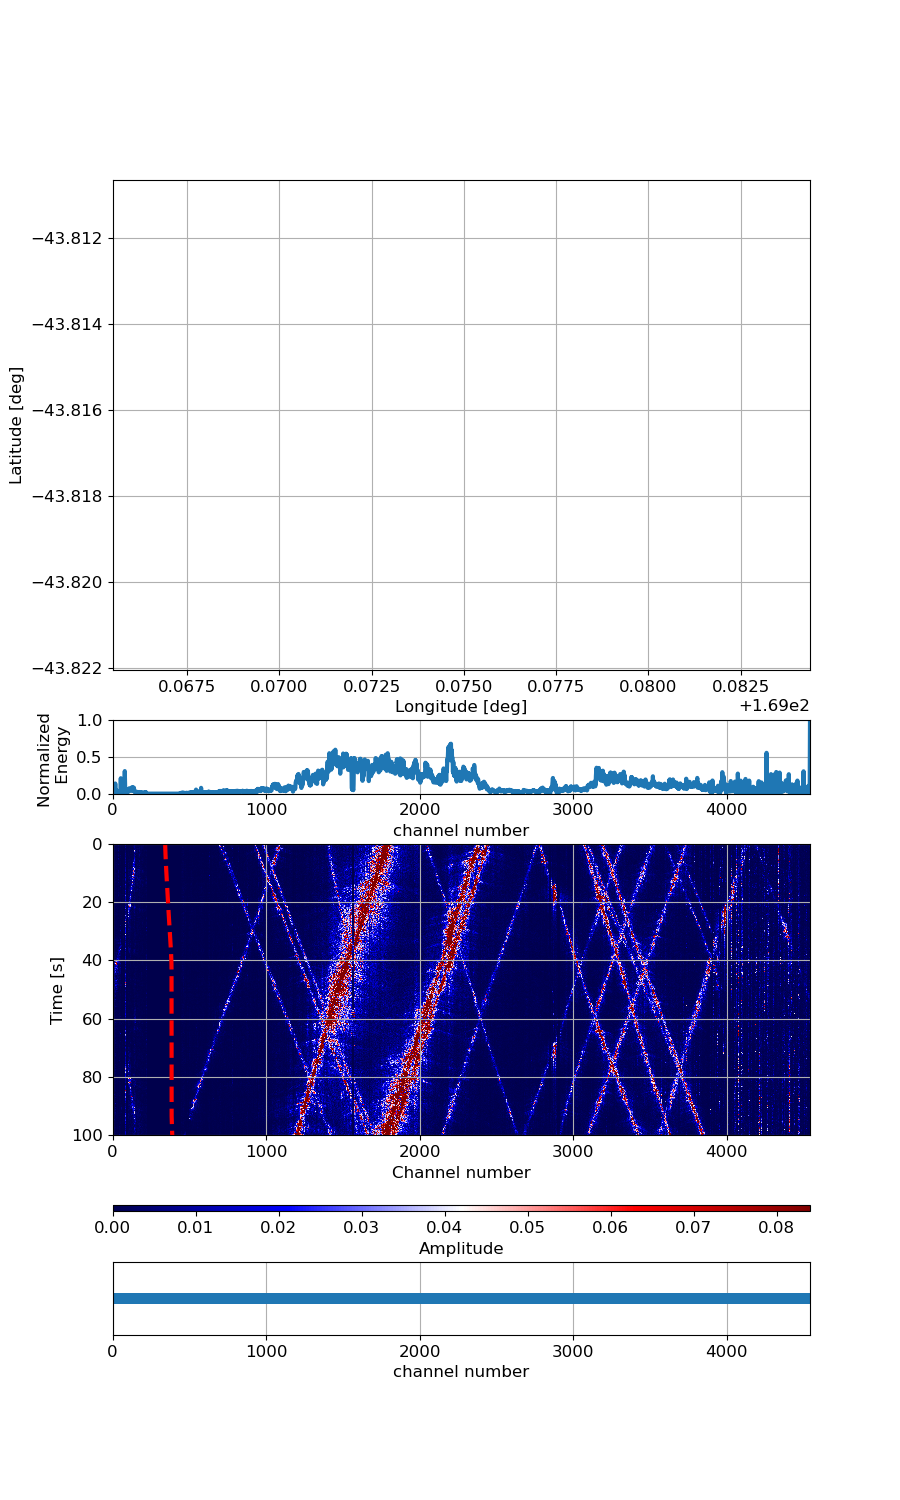

In [62]:
taptest = TapTestWdgts.taptestwdgt(dataTap, dt, dCh, gps_time, fiber_dist_vehicle, 
                                   fiber_lat[close_ch], fiber_lon[close_ch], ot)
# This is the CSV filename in which the channel positions will be saved, see cells below; it can be also
# be used to load temporary results while calibrating the channel locations
filename = "SISSLE N temp" 

To start the interactive tool, run the next cell.

In [63]:
# The if statement is useful to reload temporary results in case of errors during the calibration
# Recopy the bad channel list and uncheck the bad channel toggle button
# 1558:1570
# The plot will show the temporary progress if it was saved on file
if os.path.isfile(filename):
    ch_db = pd.read_csv(filename)
    maskNan = np.argwhere(~np.isnan(ch_db[ch_db["status"] == "good"]["latitude"].astype(float).to_numpy()))
    taptest.mapped_channels = ch_db[ch_db["status"] == "good"]["channel"].astype(int).to_numpy()[maskNan]
    taptest.mapped_lat = ch_db[ch_db["status"] == "good"]["latitude"].astype(float).to_numpy()[maskNan]
    taptest.mapped_lon = ch_db[ch_db["status"] == "good"]["longitude"].astype(float).to_numpy()[maskNan]
taptest

taptestwdgt(children=(Output(), VBox(children=(HBox(children=(Textarea(value='', continuous_update=False, desc…

The next cell can be used to save the tap test results into a temporary csv file. This file allows a user to restart the calibration from a previously saved status.

In [64]:
bad_ch = np.copy(taptest.bad_channels)
mapped_ch = np.copy(taptest.mapped_channels)
mapped_lat = np.copy(taptest.mapped_lat)
mapped_lon = np.copy(taptest.mapped_lon)
df_ch = pd.DataFrame(columns = ['channel', 'status', 'latitude', 'longitude', 'elevation'])
nCh = dataTap.shape[0]
for ich in range(nCh):
    if ich in mapped_ch:
        idx = np.argwhere(mapped_ch == ich)[0]
        df_ch.loc[str(ich)] = [ich, "good", mapped_lat[idx][0],  mapped_lon[idx][0],  np.nan]
    if ich in bad_ch:
        idx = np.argwhere(bad_ch == ich)[0]
        df_ch.loc[str(ich)] = [ich, "bad", np.nan, np.nan, np.nan]
if filename != "":
    df_ch.to_csv(filename, index=None, sep=',', mode='w')

#### Interpolating and mapping to closest fiber locations

Once all the certain channels have been located, we can interpolate the uncertain ones (i.e., the ones with no clear vehicle signal). This step allows us to geolocate channels that could not be reached by the car signal. In our case, most of the channels could be excited by the car-related deformation, so the interpolated channels are within an accuracy of approximately 5 m.

In [65]:
close_ch = TapTestWdgts.find_close_ch(mapped_lat,mapped_lon,fiber_lat,fiber_lon)
fiber_dist_taptest = fiber_dist[close_ch]
# Interpolating "uncertain" channels using fiber distance
mask_tmp = np.ones(dataTap.shape[0], dtype=bool)
mask_tmp[bad_ch] = False
channel_good = np.where(mask_tmp)[0] # indices of good channels
ChAxGood = np.arange(channel_good.shape[0])
# Mask of the mapped good channels
mask_tmp = np.zeros(channel_good.shape[0], dtype=bool)
for ich in mapped_ch:
    mask_tmp[np.argwhere(channel_good==ich)[0]] = True
# Interpolating missing good channels
f_dist = interp1d(np.where(mask_tmp)[0],fiber_dist_taptest, kind='linear', bounds_error=False)
mapped_dist_int = f_dist(ChAxGood)
f_lat = interp1d(fiber_dist,fiber_lat, kind='linear', bounds_error=False)
mapped_lat_int = f_lat(mapped_dist_int)
f_lon = interp1d(fiber_dist,fiber_lon, kind='linear', bounds_error=False)
mapped_lon_int = f_lon(mapped_dist_int)

ValueError: cannot reshape array of size 0 into shape (0,newaxis)

In [ ]:
# # Interpolating "uncertain" channels
# mask_tmp = np.ones(dataTap.shape[0], dtype=bool)
# mask_tmp[bad_ch] = False
# channel_good = np.where(mask_tmp)[0] # indices of good channels
# ChAxGood = np.arange(channel_good.shape[0])
# # Mask of the mapped good channels
# mask_tmp = np.zeros(channel_good.shape[0], dtype=bool)
# for ich in mapped_ch:
#     mask_tmp[np.argwhere(channel_good==ich)[0]] = True
# # Interpolating missing good channels
# f_lat = interp1d(np.where(mask_tmp)[0],mapped_lat, kind='linear', bounds_error=False)
# mapped_lat_int = f_lat(ChAxGood)
# f_lon = interp1d(np.where(mask_tmp)[0],mapped_lon, kind='linear', bounds_error=False)
# mapped_lon_int = f_lon(ChAxGood)

Let's visualize the mapped and interpolated channels.

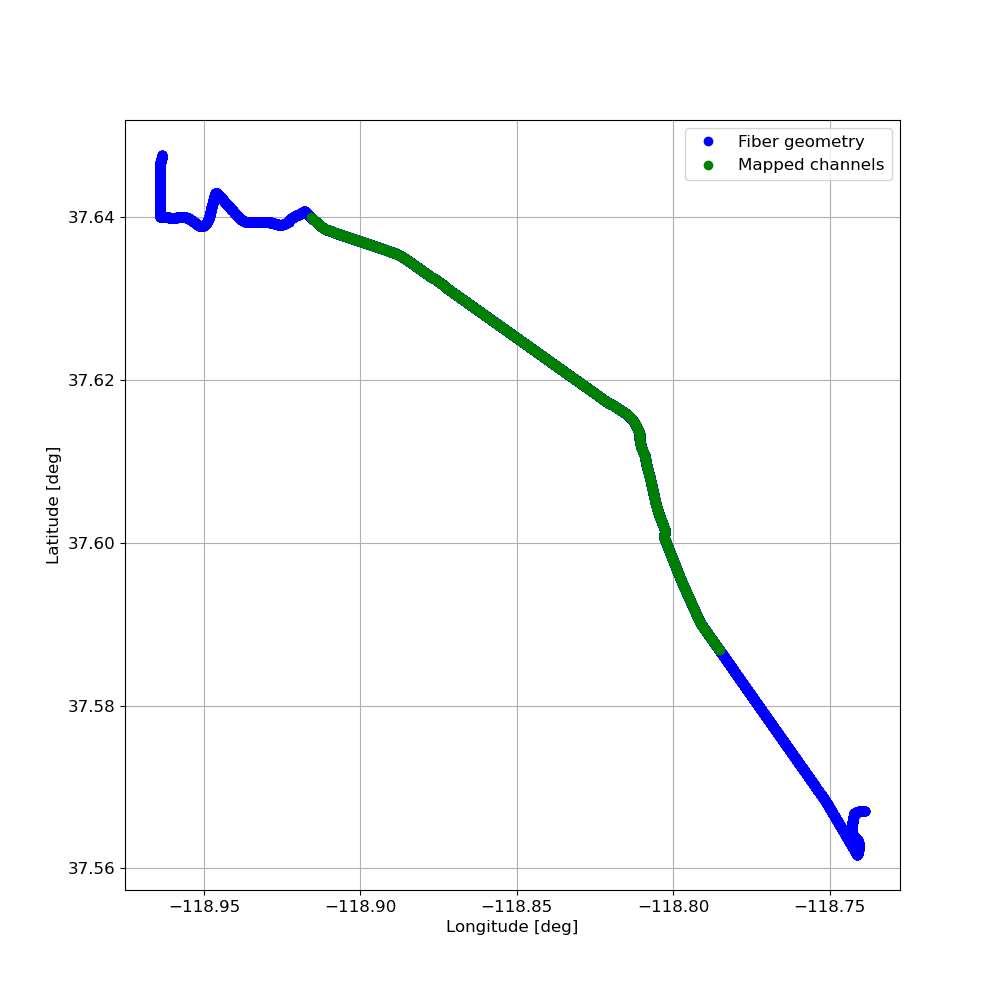

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(fiber_lon,fiber_lat,"bo",label="Fiber geometry")
ax.plot(mapped_lon_int,mapped_lat_int,"go",label="Mapped channels")
ax.set_xlabel("Longitude [deg]")
ax.set_ylabel("Latitude [deg]")
ax.legend()
ax.grid()

We can map this channels onto the more accurate fiber location with the following cell.

In [ ]:
# Projecting calibrated and interpolated positions onto fiber geometry
maskNan = np.argwhere(~np.isnan(mapped_lat_int))[:,0]
close_ch = TapTestWdgts.find_close_ch(mapped_lat_int[maskNan],mapped_lon_int[maskNan],fiber_lat,fiber_lon)
mapped_lat_int[maskNan] = fiber_lat[close_ch]
mapped_lon_int[maskNan] = fiber_lon[close_ch]

[37.64000438 37.63996743 37.63993048 ... 37.58688962 37.58683912
 37.58678391]
---
[37.64000438 37.63996743 37.63993048 ... 37.58688962 37.58683912
 37.58678391]


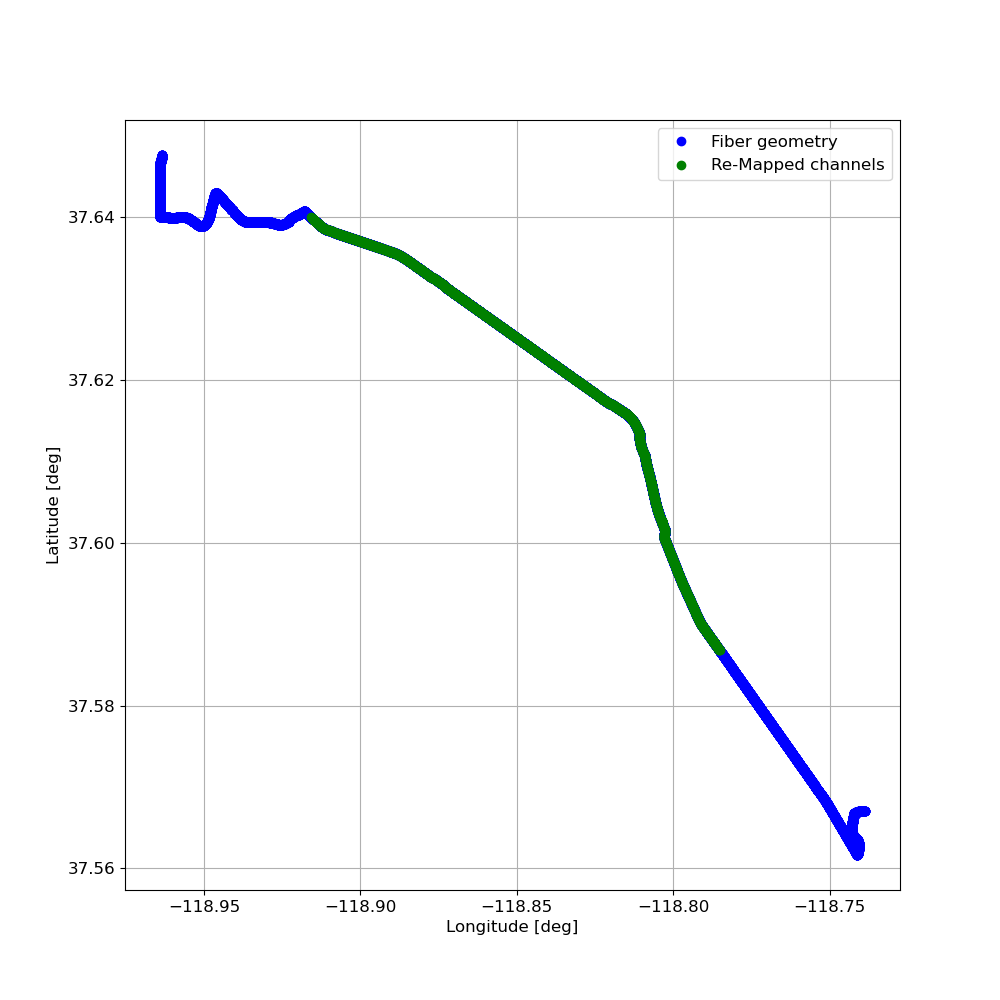

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(fiber_lon,fiber_lat,"bo",label="Fiber geometry")
ax.plot(mapped_lon_int,mapped_lat_int,"go",label="Re-Mapped channels")
ax.set_xlabel("Longitude [deg]")
ax.set_ylabel("Latitude [deg]")
ax.legend()
ax.grid()

9.598633779827956


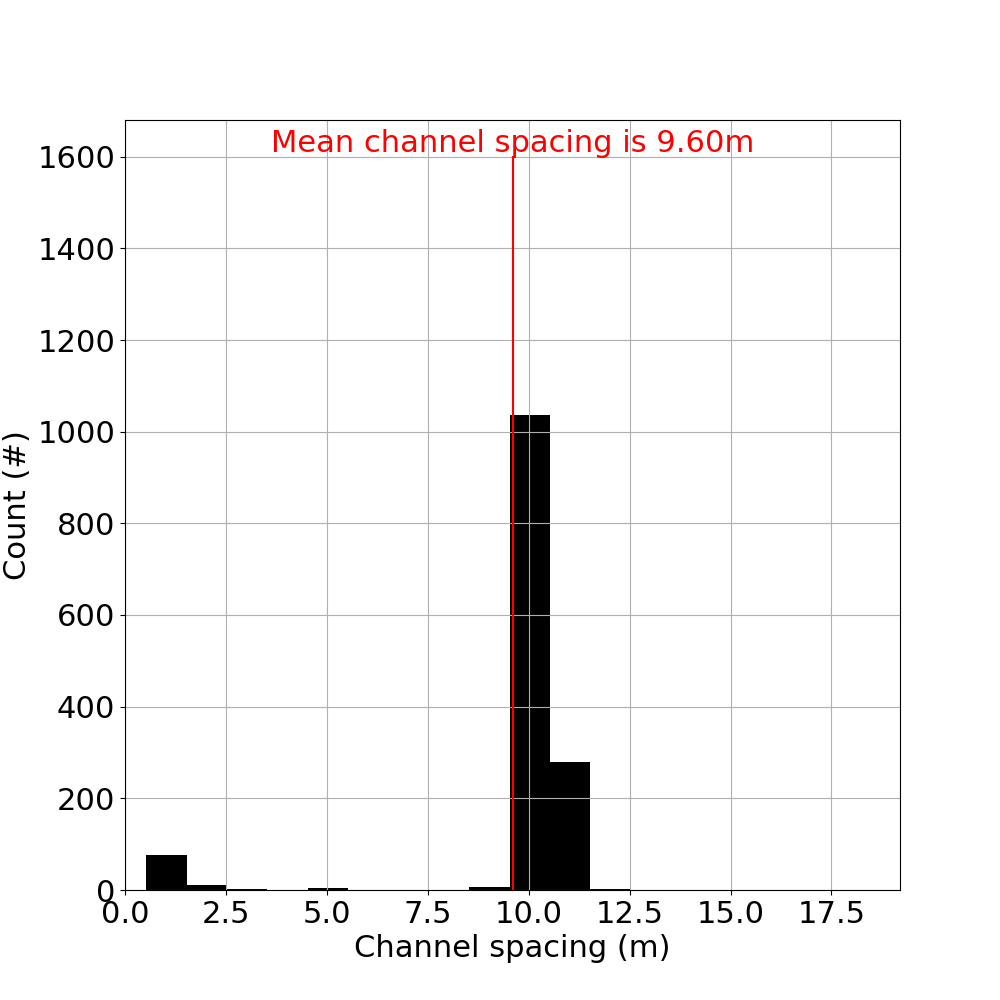

In [ ]:
# Checking channel spacing
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

params = {
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 22,  # fontsize for x and y labels (was 10)
    'axes.titlesize': 22,
    'font.size': 22,
    'legend.fontsize': 22,
    'xtick.labelsize': 22,
    'ytick.labelsize': 22,
    'text.usetex': False,
}
matplotlib.rcParams.update(params)


ch_spaces_all=[]
L_ch_spaces=np.diff(mapped_dist_int)
N_ch_spaces=np.diff(np.arange(L_ch_spaces.shape[0]+1))
ch_spaces=L_ch_spaces/N_ch_spaces
for i in range(ch_spaces.shape[0]):
    if N_ch_spaces[i] > 0 and N_ch_spaces[i] <= len(mapped_dist_int):
        ch_spaces_all=ch_spaces_all+[ch_spaces[i]]*N_ch_spaces[i]
ch_spaces_all=np.array(ch_spaces_all)
print(np.nanmean(ch_spaces_all))
fig, ax = plt.subplots(figsize=(10,10))
ax.hist(ch_spaces_all,bins=np.arange(np.nanmin(ch_spaces_all-1), np.nanmax(ch_spaces_all)+1,1),color='black')
ax.plot([np.nanmean(ch_spaces_all),np.nanmean(ch_spaces_all)],[0,1600],color='red')
ax.text(np.nanmean(ch_spaces_all),1610,"Mean channel spacing is "+'{:.2f}'.format(np.nanmean(ch_spaces_all))+"m",color='red',horizontalalignment='center')
ax.set_xlabel("Channel spacing (m)")
ax.set_ylabel("Count (#)")
ax.set_xlim((0, np.nanmean(ch_spaces_all)*2))
ax.grid()

### Getting channel elevations and writing to final output file

Finally, we can get the elevation of each channel, verify the tap-test results, and then write the final result onto a file.

In [ ]:
# # For this step you need to have pygmt installed
# import pygmt
# from scipy import interpolate
# gmt_region = [np.nanmin(mapped_lon_int)-0.1, np.nanmax(mapped_lon_int)+0.1, np.nanmin(mapped_lat_int)-0.1, np.nanmax(mapped_lat_int)+0.1]
# grid = pygmt.datasets.load_earth_relief(resolution="01s", region=gmt_region)

# LonGrid = grid.lon.values
# LatGrid = grid.lat.values
# Ele = np.flip(grid.values,axis=0)
# coord_box=np.array([[LonGrid[0],LatGrid[0]],[LonGrid[-1],LatGrid[0]],[LonGrid[0],LatGrid[-1]],[LonGrid[-1],LatGrid[-1]]])

# minLatDEM = coord_box[0,1]
# maxLatDEM = coord_box[3,1]
# minLonDEM = coord_box[0,0]
# maxLonDEM = coord_box[1,0]
# # Latitude axis 0
# # Longitude axis 1
# # first element top-left corner
# latDEMax = np.flip(np.linspace(minLatDEM,maxLatDEM,Ele.shape[0]))
# lonDEMax = np.linspace(minLonDEM,maxLonDEM,Ele.shape[1])
# f = interpolate.interp2d(lonDEMax, latDEMax, Ele, kind='linear')

# # Interpolating data
# mapped_ele_int = np.zeros_like(mapped_lat_int)
# i_not_nan = np.argwhere(~np.isnan(mapped_lat_int))[:,0]
# for idx in i_not_nan:
#     mapped_ele_int[idx] = f(mapped_lon_int[idx], mapped_lat_int[idx])

grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdcut [WARNING]: w reset from -119.015762679 to -119.015833333
grdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdcut [WARNING]: e reset from -118.685152928 to -118.685
grdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdcut [WARNING]: s reset from 37.4867839052 to 37.4866666667
grdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdcut [WARNING]: n reset from 37.7400043788 to 37.7402777778
/var/folders/q7/s_tch8ds2wl1mwwl317pqbc00000gn/T/ipykernel_79806/1387981771.py:21: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisp

In [ ]:
# # Getting elevation of each channel from USGS query form (this might take some time)
# mapped_ele_int = np.zeros_like(mapped_lat_int)
# # for idx in tqdm(maskNan):
# #     mapped_ele_int[idx] = TapTestWdgts.elevation_function(mapped_lat_int[idx],mapped_lon_int[idx])
# i_not_nan = np.argwhere(~np.isnan(mapped_lat_int))[:,0]
# n_jobs=40
# from joblib import Parallel, delayed
# from tqdm import tqdm
# output_list_with_None = Parallel(n_jobs=n_jobs)(
#         delayed(TapTestWdgts.elevation_function)(
#            mapped_lat_int[idx],
#            mapped_lon_int[idx])
#         for idx in tqdm(i_not_nan)
#     )
# for i_idx, idx in enumerate(i_not_nan):
#     mapped_ele_int[idx] = output_list_with_None[i_idx]

Now, let's verify if the calibration process provided accurate channel positions by mapping the car GPS points to the closest mapped channel.

In [ ]:
close_ch = TapTestWdgts.find_close_ch(gps_lat, gps_lon, mapped_lat_int[maskNan], mapped_lon_int[maskNan]) + maskNan[0]
close_gps_time = [tm.timestamp() - ot.timestamp() for tm in gps_time]

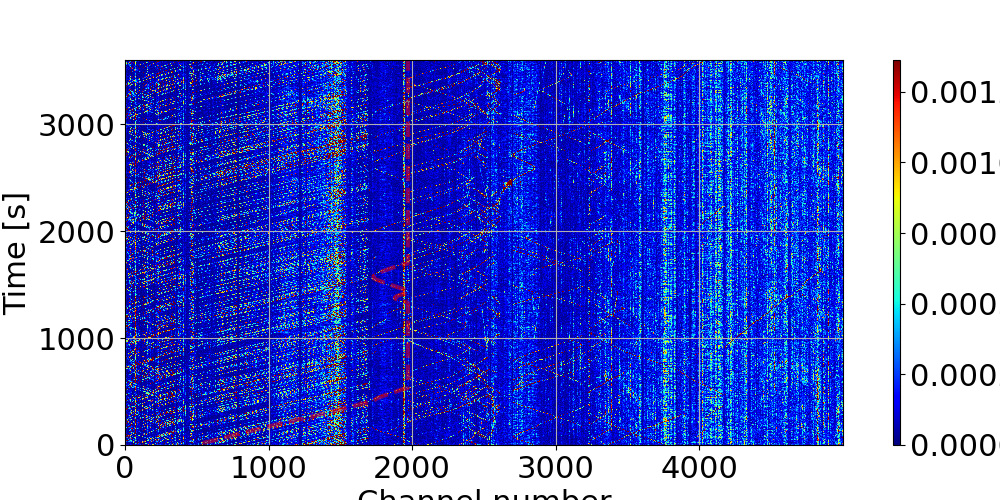

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
mask_tmp = np.ones(dataTap.shape[0], dtype=bool)
mask_tmp[bad_ch] = False
env = np.abs(hilbert(dataTap[mask_tmp,:]))
env /= env.max()
clipVal = np.percentile(np.absolute(env[:,:]), 97)
im = plt.imshow(env.T, extent=[ChAxGood[0], ChAxGood[-1], (env.shape[1]-1)*dt, 0.0],
           aspect='auto', vmin=0.0, vmax=clipVal, cmap=plt.get_cmap('jet'))
plt.plot(close_ch, close_gps_time, "r--", lw=3, alpha=0.5)
plt.ylabel("Time [s]")
plt.xlabel("Channel number")
plt.grid()
plt.ylim([(env.shape[1]-1)*dt, 0.0])
plt.gca().invert_yaxis()
# Colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.5)
cbar = plt.colorbar(im, orientation="vertical", cax=cax)
cbar.set_label('Amplitude @ 0.25-2.0 Hz')

And finally save the end result into a file.

In [ ]:
filenameFinal="SISSLE N output"
df_ch = pd.DataFrame(columns = ['channel', 'status', 'latitude', 'longitude', 'elevation'])
for ich in range(nCh):
    if ich in channel_good:
        idx = np.argwhere(channel_good == ich)[0]
        df_ch.loc[str(ich)] = [ich, "good", mapped_lat_int[idx][0],  mapped_lon_int[idx][0],  mapped_ele_int[idx][0]]
    if ich in bad_ch:
        idx = np.argwhere(bad_ch == ich)[0]
        df_ch.loc[str(ich)] = [ich, "bad", np.nan, np.nan, np.nan]
df_ch.to_csv(filenameFinal, index=None, sep=',', mode='w')